In [21]:
import pandas as pd
import statistics
from matplotlib import pyplot as plt

import numpy as np
import sklearn.linear_model as skl
from sklearn.metrics import r2_score

from scipy import stats as st
import scipy as sc

Lettura dati e giochi vari

In [22]:
#LETTURA NASA
totale = pd.read_csv("/home/francesco/Codici/Computazionale/dc0/GLB.Ts+dSST.csv" , header = 1)
col = ['Year',"Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
totale[col] = totale[col].apply(pd.to_numeric, errors = 'coerce')

#Anni
Anni = totale['Year']

#medie per ano
totale.drop(['Year' , 'J-D' , 'DJF' , 'MAM' , 'JJA' , 'SON' , 'D-N'] , axis = 1 , inplace= True)
medie = totale.mean(axis = 1 , skipna= True , numeric_only= True)

#devstd
devstd = totale.T.std()

#DataFrame
totale = {'Year' : Anni , 'Median' : medie  , 'Devstd' : devstd}
Nasa = pd.DataFrame(totale)

#LETTURA HAD
Had = pd.read_csv("/home/francesco/Codici/Computazionale/dc0/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv" , header = 0 )

#LETTURA NOAA
Noaa = pd.read_csv('/home/francesco/Codici/Computazionale/dc0/data.csv' , header = 4)

#LETTURA JAPAN
Japan = pd.read_csv('/home/francesco/Codici/Computazionale/dc0/year_wld.csv')

#LETTURA BERKELEY
indice = ['Year', 'Annual Anomaly', 'Annual Unc.', 'Five-year Anomaly', 'Five-year Unc.', 'Annual Anomaly Under', 'Annual Unc. Under', 'Five-year Anomaly Under', 'Five-year Unc. Under']
Berkeley = pd.read_fwf('/home/francesco/Codici/Computazionale/dc0/Land_and_Ocean_summary.txt' , header = None , names = indice, skiprows = 57 )

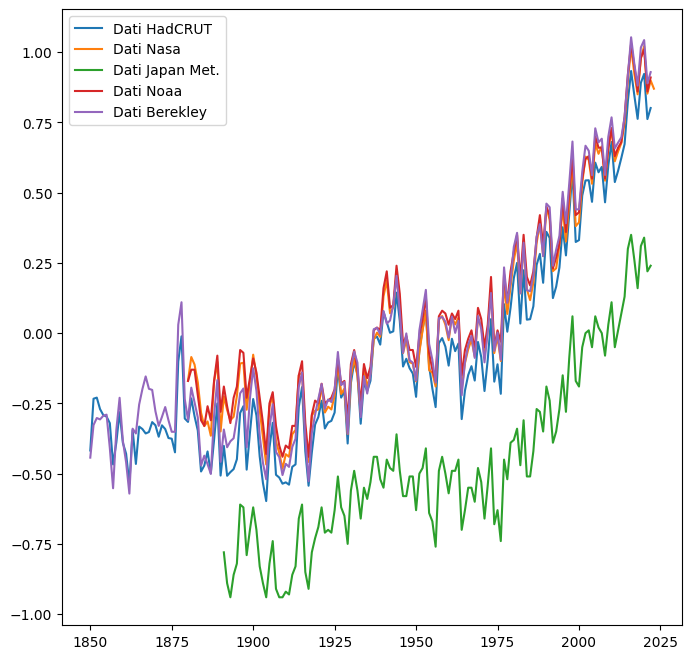

In [23]:
#Dati bruti
plt.plot(Had['Time'] , Had['Anomaly (deg C)'] , label = "Dati HadCRUT")
plt.plot(Nasa['Year'] , Nasa['Median'], label = "Dati Nasa")
plt.plot(Japan['Year'] , Japan['Global'] , label = "Dati Japan Met.")
plt.plot(Noaa['Year'] , Noaa['Value'], label = "Dati Noaa")
plt.plot(Berkeley['Year'] , Berkeley['Annual Anomaly'] , label = "Dati Berekley" )
plt.legend()
plt.show()

Metto tutti sulla stessa base (media riferita a 1961-1990)

In [24]:
def traslazione(data) : 
    copia = data
    filtro_post = copia[copia.iloc[:,0] < 1961].index
    filtro_pre = copia[copia.iloc[:,0] > 1990].index

    dati_medi = copia.drop(filtro_pre)
    dati_medi.drop(filtro_post, inplace= True)

    dati_traslati = copia
    dati_traslati.iloc[:,1] = dati_traslati.iloc[:,1] - dati_medi.iloc[:,1].mean()

    #Tagliato per inizio uguale (da capire)
    filtro_post = copia[copia.iloc[:,0] < 1891].index
    dati_traslati.drop(filtro_post , inplace = True)

    return dati_traslati

In [25]:
Nasa_copia = Nasa
Japan_copia = Japan
Noaa_copia = Noaa
Had_copia = Had
Berkeley_copia = Berkeley

Nasa_fixed = traslazione(Nasa_copia)
Japan_fixed = traslazione(Japan_copia)
Noaa_fixed = traslazione(Noaa_copia)
Had_fixed = traslazione(Had_copia)
Berkeley_fixed = traslazione(Berkeley_copia)

plt.grid()
plt.plot(Had_fixed['Time'] , Had_fixed['Anomaly (deg C)'] , label = "Dati HadCRUT")
plt.plot(Nasa_fixed['Year'] , Nasa_fixed['Median'], label = "Dati Nasa")
plt.plot(Japan_fixed['Year'] , Japan_fixed['Global'] , label = "Dati Japan Met.")
plt.plot(Noaa_fixed['Year'] , Noaa_fixed['Value'], label = "Dati Noaa")
plt.plot(Berkeley_fixed['Year'] , Berkeley_fixed['Annual Anomaly'] , label = "Dati Berekley" )
plt.legend()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

Prendo miglior quadratica su Had

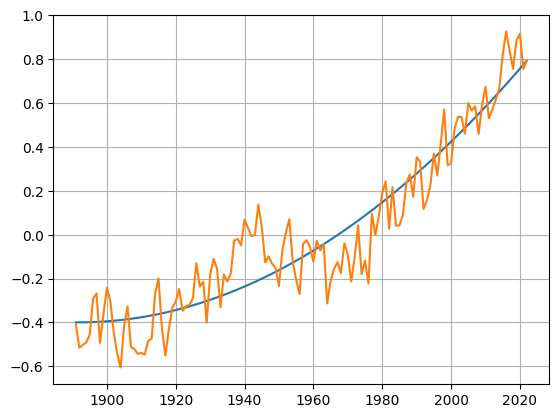

In [ ]:
#valori medi
p = np.polyfit(Had['Time'] , Had['Anomaly (deg C)']  , 2 )
y_fitted = np.zeros(Had['Time'].count())
x_fitted = np.linspace(np.min(Had['Time']), np.max(Had['Time']), Had['Time'].count())
for i in range(3) : 
    y_fitted += p[i] * x_fitted**(2-i)
plt.plot(x_fitted , y_fitted)
plt.plot(Had['Time'] , Had['Anomaly (deg C)'])
plt.grid()

cerco quadratica ed esponenziale

In [ ]:
def r2_score_powerlow(data , coefficienti) : 
    x = data.iloc[:,0]
    y_fitted = np.zeros(len(x))
    for i in range(len(p)) : 
        y_fitted += coefficienti[i] * x**(len(p)-1-i)
    
    chi = r2_score(data.iloc[:,1] , y_fitted)
    return chi

In [ ]:
def r2_score_exp(data , coefficienti) : 
    x = data.iloc[:,0]
    y_fitted = np.exp(coefficienti[1]) * np.exp(coefficienti[0] * x) -1
    
    chi = r2_score(data.iloc[:,1] , y_fitted)
    return chi

In [ ]:
p = np.polyfit(Had['Time'] , Had['Anomaly (deg C)']  , 2 )
risultati_quadratica = [r2_score_powerlow(Berkeley_fixed , p) ,  r2_score_powerlow(Had , p),r2_score_powerlow(Nasa_fixed , p),r2_score_powerlow(Noaa_fixed , p),r2_score_powerlow(Japan_fixed , p)]

risultati_quadratica

[0.9009218410301849,
 0.8829217142562891,
 0.8947314612446184,
 0.8934812118056021,
 0.7983976980766598]

In [ ]:
p_exp = np.polyfit(Had['Time'] , np.log(Had['Anomaly (deg C)'] + 1) , 1)

risultati_exp = [r2_score_exp(Berkeley_fixed , p_exp) ,  r2_score_exp(Had , p_exp),r2_score_exp(Nasa_fixed , p_exp),r2_score_exp(Noaa_fixed , p_exp),r2_score_exp(Japan_fixed , p_exp)]

risultati_exp



[0.8880074987128704,
 0.8749697564605703,
 0.8751877941445583,
 0.8773668298869356,
 0.7961627629109236]

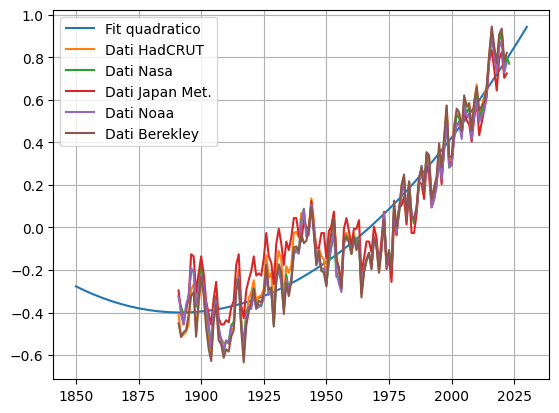

In [ ]:
x_fitted = np.linspace(1850 , 2030)
y_fitted = np.zeros(len(x_fitted))
for i in range(3) : 
    y_fitted += p[i] * x_fitted**(2-i)

plt.grid()
plt.plot(x_fitted , y_fitted ,label = "Fit quadratico")
plt.plot(Had_fixed['Time'] , Had_fixed['Anomaly (deg C)'] , label = "Dati HadCRUT")
plt.plot(Nasa_fixed['Year'] , Nasa_fixed['Median'], label = "Dati Nasa")
plt.plot(Japan_fixed['Year'] , Japan_fixed['Global'] , label = "Dati Japan Met.")
plt.plot(Noaa_fixed['Year'] , Noaa_fixed['Value'], label = "Dati Noaa")
plt.plot(Berkeley_fixed['Year'] , Berkeley_fixed['Annual Anomaly'] , label = "Dati Berekley" )
plt.legend()

Dimostro + grafico che non può essere oscillazione statistica

In [ ]:
p_Nasa = st.normaltest(Nasa['Year'])[1]
p_Had = st.normaltest(Had['Time'])[1]
p_Japan = st.normaltest(Japan['Year'])[1]
p_Berkeley = st.normaltest(Berkeley['Year'])[1]
p_Noaa = st.normaltest(Noaa['Year'])[1]


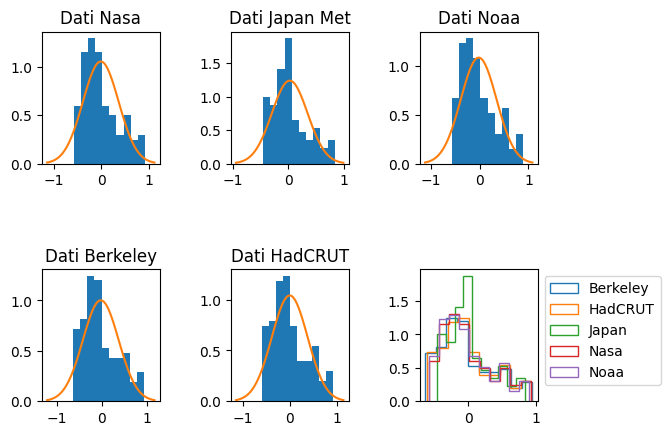

In [ ]:
fig , axs = plt.subplots(2, 3)

#Noaa
mu = Noaa_fixed['Value'].mean()
sigma = Noaa_fixed['Value'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axs[0,2].hist(Noaa_fixed['Value'] , density = True)
axs[0,2].plot(x , st.norm.pdf(x , mu, sigma))
axs[0,2].set_title("Dati Noaa")

#Nasa
mu = Nasa_fixed['Median'].mean()
sigma = Nasa_fixed['Median'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axs[0,0].hist(Nasa_fixed['Median'] , density = True)
axs[0,0].plot(x , st.norm.pdf(x , mu, sigma))
axs[0,0].set_title("Dati Nasa")

#Japan
mu = Japan_fixed['Global'].mean()
sigma = Japan_fixed['Global'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axs[0,1].hist(Japan_fixed['Global'] , density = True)
axs[0,1].plot(x , st.norm.pdf(x , mu, sigma))
axs[0,1].set_title("Dati Japan Met")

#Had
mu = Had['Anomaly (deg C)'].mean()
sigma = Had['Anomaly (deg C)'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axs[1,1].hist(Had['Anomaly (deg C)'] , density = True)
axs[1,1].plot(x , st.norm.pdf(x , mu, sigma))
axs[1,1].set_title("Dati HadCRUT")

#Berkeley
mu = Berkeley_fixed['Annual Anomaly'].mean()
sigma = Berkeley_fixed['Annual Anomaly'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axs[1,0].hist(Berkeley_fixed['Annual Anomaly'] , density = True)
axs[1,0].plot(x , st.norm.pdf(x , mu, sigma))
axs[1,0].set_title("Dati Berkeley")

#Tutto insieme
axs[1,2].hist(Berkeley_fixed['Annual Anomaly'] , density = True , histtype="step" , label = "Berkeley")
axs[1,2].hist(Had['Anomaly (deg C)'] , density = True , histtype="step" , label = "HadCRUT")
axs[1,2].hist(Japan_fixed['Global'] , density = True , histtype="step", label = "Japan")
axs[1,2].hist(Nasa_fixed['Median'] , density = True, histtype="step" , label = "Nasa")
axs[1,2].hist(Noaa_fixed['Value'] , density = True, histtype = "step" , label = "Noaa")
axs[1,2].legend(bbox_to_anchor = (1,1))


fig.subplots_adjust(hspace=0.8, wspace=0.6)
plt.rcParams['figure.figsize'] = [8,8]

In [ ]:
def var_post75(data) : 
    filtro_post = data[data.iloc[:,0] < 1980].index
    data.drop(filtro_post , inplace = True)
    appo = np.zeros(data.iloc[:,0].count())
    for i in range(data.iloc[:,0].count() - 1) :
        appo[i] = abs(data.iloc[i + 1, 1] - data.iloc[i , 1])
    
    return appo.mean()

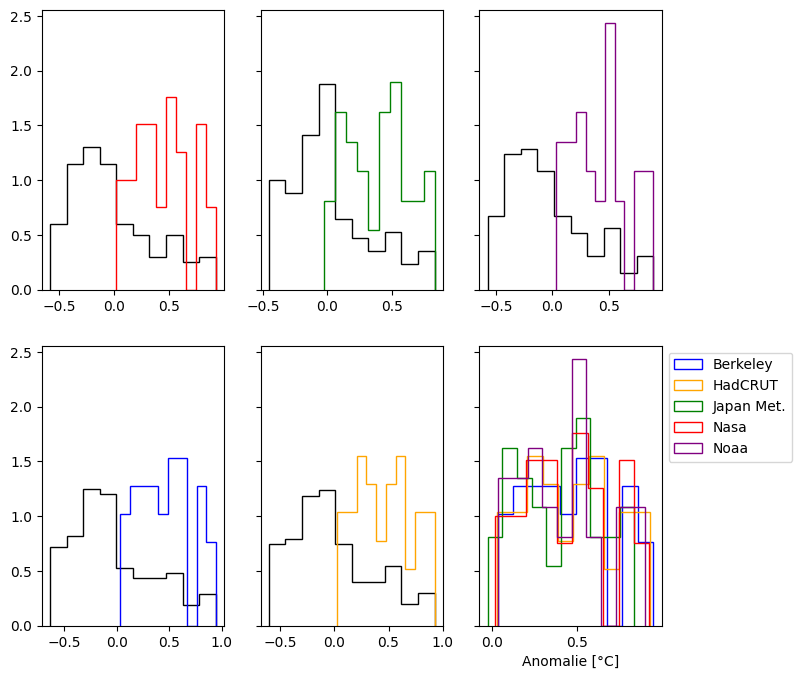

In [ ]:
fig , axs = plt.subplots(2, 3  ,  sharey=True)

#Noaa
axs[0,2].hist(Noaa_fixed['Value'] , density = True , color = 'black' , histtype="step")
sigma = var_post75(Noaa_fixed)
mu = Noaa_fixed['Value'].mean()
x = np.linspace(-0.5, 1.5 , 100)
axs[0,2].hist(Noaa_fixed['Value'] , density = True , color = 'purple' , histtype="step")

#Nasa
axs[0,0].hist(Nasa_fixed['Median'] , density = True , color = 'black' , histtype="step")
sigma = var_post75(Nasa_fixed)
mu = Nasa_fixed['Median'].mean()
axs[0,0].hist(Nasa_fixed['Median'] , density = True , color = 'red' , histtype="step")

#Japan
axs[0,1].hist(Japan_fixed['Global'] , density = True , color = 'black' , histtype="step")
sigma = var_post75(Japan_fixed)
mu = Japan_fixed['Global'].mean()
axs[0,1].hist(Japan_fixed['Global'] , density = True , color = 'green' , histtype="step")

#Had
axs[1,1].hist(Had_fixed['Anomaly (deg C)'] , density = True , color = 'black' , histtype="step")
sigma = var_post75(Had_fixed)
mu = Had_fixed['Anomaly (deg C)'].mean()
axs[1,1].hist(Had_fixed['Anomaly (deg C)'] , density = True , color = 'orange' , histtype="step")

#Berkeley
axs[1,0].hist(Berkeley_fixed['Annual Anomaly'] , density = True , histtype="step" , color = 'black')
sigma = var_post75(Berkeley_fixed)
mu = Berkeley_fixed['Annual Anomaly'].mean()
axs[1,0].hist(Berkeley_fixed['Annual Anomaly'] , density = True , histtype="step" , color = 'blue')

#Tutto insieme
axs[1,2].hist(Berkeley_fixed['Annual Anomaly'] , density = True , histtype="step" , label = "Berkeley" , color = 'blue')
axs[1,2].hist(Had_fixed['Anomaly (deg C)'] , density = True , histtype="step" , label = "HadCRUT" , color = 'orange')
axs[1,2].hist(Japan_fixed['Global'] , density = True , histtype="step", label = "Japan Met." , color = 'green')
axs[1,2].hist(Nasa_fixed['Median'] , density = True, histtype="step" , label = "Nasa" , color = 'red')
axs[1,2].hist(Noaa_fixed['Value'] , density = True, histtype = "step" , label = "Noaa" , color = 'purple')
axs[1,2].legend(bbox_to_anchor = (1,1))

plt.xlabel("Anomalie [°C]")
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.rcParams['figure.figsize'] = [8,8]

In [ ]:
#LETTURA NASA
totale = pd.read_csv("/home/francesco/Codici/Computazionale/dc0/GLB.Ts+dSST.csv" , header = 1)
col = ['Year',"Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
totale[col] = totale[col].apply(pd.to_numeric, errors = 'coerce')
#Anni
Anni = totale['Year']
#medie per ano
totale.drop(['Year' , 'J-D' , 'DJF' , 'MAM' , 'JJA' , 'SON' , 'D-N'] , axis = 1 , inplace= True)
medie = totale.mean(axis = 1 , skipna= True , numeric_only= True)
#devstd
devstd = totale.T.std()
#DataFrame
totale = {'Year' : Anni , 'Median' : medie  , 'Devstd' : devstd}
Nasa = pd.DataFrame(totale)
#LETTURA HAD
Had = pd.read_csv("/home/francesco/Codici/Computazionale/dc0/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv" , header = 0 )
#LETTURA NOAA
Noaa = pd.read_csv('/home/francesco/Codici/Computazionale/dc0/data.csv' , header = 4)
#LETTURA JAPAN
Japan = pd.read_csv('/home/francesco/Codici/Computazionale/dc0/year_wld.csv')
#LETTURA BERKELEY
indice = ['Year', 'Annual Anomaly', 'Annual Unc.', 'Five-year Anomaly', 'Five-year Unc.', 'Annual Anomaly Under', 'Annual Unc. Under', 'Five-year Anomaly Under', 'Five-year Unc. Under']
Berkeley = pd.read_fwf('/home/francesco/Codici/Computazionale/dc0/Land_and_Ocean_summary.txt' , header = None , names = indice, skiprows = 57 )

Nasa_fixed = traslazione(Nasa)
Japan_fixed = traslazione(Japan)
Noaa_fixed = traslazione(Noaa)
Had_fixed = traslazione(Had)
Berkeley_fixed = traslazione(Berkeley)

var_Nasa = var_post75(Nasa_fixed)
var_Japan = var_post75(Japan_fixed)
var_Had = var_post75(Had_fixed)
var_Noaa = var_post75(Noaa_fixed)
var_Berkeley = var_post75(Berkeley_fixed)


In [ ]:
def retta(data) : 
    m = np.polyfit(data.iloc[:,0] , data.iloc[:,1] , 1 ) 
    x = np.linspace(np.min(data.iloc[:,0]), np.max(data.iloc[:,0]), data.iloc[:,0].count())
    y_fitted = m[0] * x+ m[1]

    data.iloc[:,1] = data.iloc[:,1] - y_fitted

    plt.plot(data.iloc[:,0] , data.iloc[:,1] , label = "Dati {data}" )
    plt.legend()

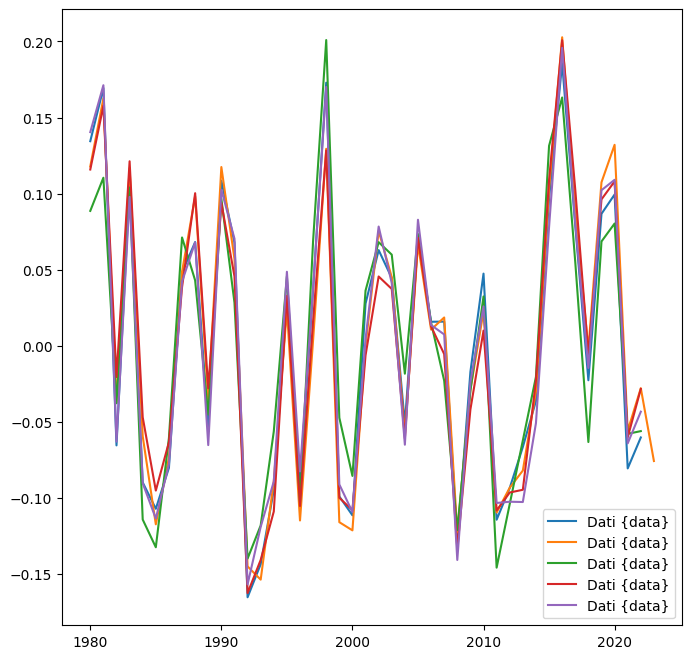

In [ ]:
retta(Had_fixed)
retta(Nasa_fixed)
retta(Japan_fixed)
retta(Noaa_fixed)
retta(Berkeley_fixed)

In [ ]:
def histo(data) : 
    plt.hist(data.iloc[:,1] , label = 'Dati' , density= True , histtype= 'step')
    plt.legend()

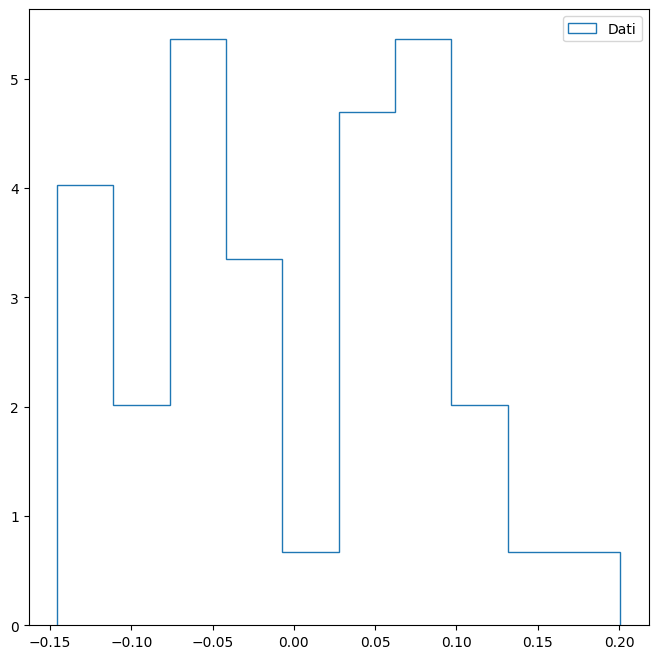

In [ ]:
histo(Japan_fixed)
